# Phase 4: final model and analysis

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, f1_score, confusion_matrix, precision_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

/Users/ralphkaijim/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Feature engineering

In [2]:
# Open the csv file with the data
csv_file = 'BPI_Challenge_2017.csv'
df = pd.read_csv(csv_file)

# Turn time into a timestamp
df = df[df['lifecycle:transition'] == 'COMPLETE'].copy()
df['time'] = pd.to_datetime(df['time'], format='%Y/%m/%d %H:%M:%S.%f')

# Function to check if 'A_Pending' is present in a case
def is_accepted(events):
    return 'A_Pending' in events.values

# Apply the function to each group and map the results to the original DataFrame
accepted_cases = df.groupby('case')['event'].apply(is_accepted)
df['Accepted'] = df['case'].map(accepted_cases).astype(int)
df['EventCount'] = df.groupby('case').cumcount()

## Event encoding

In [3]:
label_encoder = LabelEncoder()
df['event'] = label_encoder.fit_transform(df['event'])
print({index: label for index, label in enumerate(label_encoder.classes_)})

{0: 'A_Accepted', 1: 'A_Cancelled', 2: 'A_Complete', 3: 'A_Concept', 4: 'A_Create Application', 5: 'A_Denied', 6: 'A_Incomplete', 7: 'A_Pending', 8: 'A_Submitted', 9: 'A_Validating', 10: 'O_Accepted', 11: 'O_Cancelled', 12: 'O_Create Offer', 13: 'O_Created', 14: 'O_Refused', 15: 'O_Returned', 16: 'O_Sent (mail and online)', 17: 'O_Sent (online only)', 18: 'W_Assess potential fraud', 19: 'W_Call after offers', 20: 'W_Call incomplete files', 21: 'W_Complete application', 22: 'W_Handle leads', 23: 'W_Validate application'}


## DataFrame offer attributes

In [4]:
# offer features at time of offer
df_offer = df[df['event'] == 12].drop(['lifecycle:transition', 'Selected', 'OfferID', 'Action', 'EventOrigin', 'CreditScore'], axis=1)
# df_offer['amount_difference'] = df_offer['RequestedAmount'] - df_offer['OfferedAmount']

# Feature scaling
scaler = StandardScaler()
df_offer[['RequestedAmount', 'MonthlyCost', 'FirstWithdrawalAmount', 'NumberOfTerms', 'OfferedAmount']] = scaler.fit_transform(df_offer[['RequestedAmount', 'MonthlyCost', 'FirstWithdrawalAmount', 'NumberOfTerms', 'NumberOfTerms']])

## Prefix attribute

In [5]:
# event_ids = df_offer['EventID']

# prefix_list = []

# #take the sequence of events before and including the O_Create Offer event and label encode the event names
# #they are stored in prefix_list
# for eventID in tqdm_notebooktqdm(event_ids.values):
#     case_id = df[df['EventID'] == eventID]['case'].iloc[0]
#     indexEvent =  df[df['EventID'] == eventID]['EventCount'].iloc[0]+1
#     df_case = df[df['case'] == case_id].copy()
#     df_case = df_case['event'].iloc[:indexEvent].copy()
    
#     li = [str(x) for x in df_case.tolist()]
#     seq_str = "".join(li)
    
#     prefix_list.append(seq_str)
    
# # Save the lists
# with open('prefix_list.pkl', 'wb') as f:
#     pickle.dump(prefix_list, f)

In [6]:
# Load the lists with the prefix of every offer
with open('prefix_list.pkl', 'rb') as f:
    prefix_list = pickle.load(f)
    
label_encoder = LabelEncoder()

df_offer['prefix'] = prefix_list

# reduce the amount of different prefix labels by grouping the less frequent prefixes
value_counts = df_offer['prefix'].value_counts()
values_to_zero = value_counts[16:].index #The less frequent prefixes which are 10% of all the offers
df_offer.loc[df_offer['prefix'].isin(values_to_zero), 'prefix'] = 0

### Dummie encoded

In [7]:
column_names = ['LoanGoal', 'ApplicationType', 'prefix']
# We use One-Hot Encoding for all categorical variables
df_offer_dum = pd.get_dummies(df_offer, columns=column_names, prefix_sep='_')

## Split the data in training and test sets

In [8]:
# Split the data in X and y
X = df_offer_dum.drop(['Accepted', 'case', 'event', 'time', 'org:resource', 'EventID'], axis=1)  # Features (all columns except 'Accepted')
y = df_offer_dum['Accepted']  # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Naive predictor

In [9]:
# Create KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
accuracies = []
f1_scores = []

for train_index_base, test_index_base in kf.split(X):
    # Splitting data into train and test for this fold
    X_train_base, X_test_base = X.iloc[train_index_base], X.iloc[test_index_base]
    y_train_base, y_test_base = y.iloc[train_index_base], y.iloc[test_index_base]

    # Naive prediction: randomly assign True or False to each test case
    predicted_accepted = np.random.choice([0, 1], size=len(y_test_base))

    # Calculate the accuracy and F1-score for the naive predictor on the validation set
    accuracy = round(accuracy_score(y_test_base, predicted_accepted), 4)
    f1 = round(f1_score(y_test_base, predicted_accepted), 4)

    # Append scores to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

print("Logistic Regression classifier \n")
# Display scores for each fold
print("Accuracy scores for each fold:")
print(accuracies)

print("F1-scores for each fold:")
print(f1_scores)

# Display mean scores across all folds
print("\nMean accuracy across all folds:")
print(round(np.mean(accuracies), 4))

print("Mean F1-score across all folds:")
print(round(np.mean(f1_scores), 4))

Logistic Regression classifier 

Accuracy scores for each fold:
[0.4982, 0.4941, 0.508, 0.4994, 0.4937]
F1-scores for each fold:
[0.5284, 0.526, 0.5352, 0.5267, 0.5228]

Mean accuracy across all folds:
0.4987
Mean F1-score across all folds:
0.5278


# Logistic regression

In [10]:
# Create KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
accuracies = []
f1_scores = []

for train_index_base, test_index_base in tqdm_notebook(kf.split(X)):
    # Splitting data into train and test for this fold
    X_train_base, X_test_base = X.iloc[train_index_base], X.iloc[test_index_base]
    y_train_base, y_test_base = y.iloc[train_index_base], y.iloc[test_index_base]

    #train SGD
    sgd = SGDClassifier()

    sgd.fit(X_train_base, y_train_base)

    # Prediction using trained SGD classifier
    predicted_accepted = sgd.predict(X_test_base)

    # Calculate the accuracy and F1-score for the SGD predictor on the validation set
    accuracy = round(accuracy_score(y_test_base, predicted_accepted), 4)
    f1 = round(f1_score(y_test_base, predicted_accepted), 4)

    # Append scores to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

print("SGD classifier \n")
# Display scores for each fold
print("Accuracy scores for each fold:")
print(accuracies)

print("F1-scores for each fold:")
print(f1_scores)

# Display mean scores across all folds
print("\nMean accuracy across all folds:")
print(round(np.mean(accuracies), 4))

print("Mean F1-score across all folds:")
print(round(np.mean(f1_scores), 4))

0it [00:00, ?it/s]

SGD classifier 

Accuracy scores for each fold:
[0.591, 0.5922, 0.5415, 0.5922, 0.5896]
F1-scores for each fold:
[0.692, 0.7158, 0.4576, 0.7135, 0.7176]

Mean accuracy across all folds:
0.5813
Mean F1-score across all folds:
0.6593


# Support Vector Machine

In [11]:
# Create KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
accuracies = []
f1_scores = []

for train_index_base, test_index_base in tqdm_notebook(kf.split(X)):
    # Splitting data into train and test for this fold
    X_train_base, X_test_base = X.iloc[train_index_base], X.iloc[test_index_base]
    y_train_base, y_test_base = y.iloc[train_index_base], y.iloc[test_index_base]

    #train SVM classifier
    svm=LinearSVC(C=0.0001,max_iter=10000)

    svm.fit(X_train_base, y_train_base)

    # Prediction using trained SVM classifier
    predicted_accepted = svm.predict(X_test_base)

    # Calculate the accuracy and F1-score for the SVM predictor on the validation set
    accuracy = round(accuracy_score(y_test_base, predicted_accepted), 4)
    f1 = round(f1_score(y_test_base, predicted_accepted), 4)

    # Append scores to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

print("SVM classifier \n")
# Display scores for each fold
print("Accuracy scores for each fold:")
print(accuracies)

print("F1-scores for each fold:")
print(f1_scores)

# Display mean scores across all folds
print("\nMean accuracy across all folds:")
print(round(np.mean(accuracies), 4))

print("Mean F1-score across all folds:")
print(round(np.mean(f1_scores), 4))

0it [00:00, ?it/s]

SVM classifier 

Accuracy scores for each fold:
[0.5931, 0.586, 0.582, 0.5955, 0.5945]
F1-scores for each fold:
[0.6942, 0.6868, 0.6867, 0.6974, 0.6972]

Mean accuracy across all folds:
0.5902
Mean F1-score across all folds:
0.6925


# Random Forest

In [12]:
# Create KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Lists to store the scores for each fold
accuracies = []
f1_scores = []

for train_index_base, test_index_base in kf.split(X):
    # Splitting data into train and test for this fold
    X_train_base, X_test_base = X.iloc[train_index_base], X.iloc[test_index_base]
    y_train_base, y_test_base = y.iloc[train_index_base], y.iloc[test_index_base]

    #train Random Forest classifier
    rf = RandomForestClassifier(n_estimators=45,max_depth=35)

    rf.fit(X_train_base, y_train_base)

    # Prediction using trained Random Forest classifier
    predicted_accepted = rf.predict(X_test_base)

    # Calculate the accuracy and F1-score for the Random Forest predictor on the validation set
    accuracy = round(accuracy_score(y_test_base, predicted_accepted), 4)
    f1 = round(f1_score(y_test_base, predicted_accepted), 4)

    # Append scores to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)

print("Random Forest classifier \n")
# Display scores for each fold
print("Accuracy scores for each fold:")
print(accuracies)

print("F1-scores for each fold:")
print(f1_scores)

# Display mean scores across all folds
print("\nMean accuracy across all folds:")
print(round(np.mean(accuracies), 4))

print("Mean F1-score across all folds:")
print(round(np.mean(f1_scores), 4))

Random Forest classifier 

Accuracy scores for each fold:
[0.6008, 0.5944, 0.5924, 0.5959, 0.5967]
F1-scores for each fold:
[0.6594, 0.6549, 0.6518, 0.6554, 0.656]

Mean accuracy across all folds:
0.596
Mean F1-score across all folds:
0.6555


# Neural Network

## Feature importance NN

In [13]:
def train_model_without_feature(X, y, excluded_feature):
    # Setup model
    learning_rate=0.001
    hidden_layer_act='LeakyReLU'
    output_layer_act='sigmoid'
    no_epochs=200
    
    # Exclude the feature
    X_modified = X.drop(excluded_feature, axis=1)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_modified, y, test_size=0.2, random_state=42)

    # Define model
    model = Sequential()
    model.add(Dense(16, input_dim=X_train.shape[1], activation=hidden_layer_act))
    model.add(Dense(32, activation=hidden_layer_act))
    model.add(Dense(64, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    # Compile model
    adam = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

    # Fit model
    model.fit(X_train, y_train, epochs=no_epochs, batch_size=32, verbose=0, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # Evaluate model
    scores = model.evaluate(X_test, y_test, verbose=0)
    return scores[1]  # Return accuracy

# List to store accuracy
accuracy_list_lovo = {}

#the LOVO with the dummie features bundeled
exclude_feature_comb = [[],
                        ['RequestedAmount'], 
                        ['MonthlyCost'], 
                        ['FirstWithdrawalAmount'],
                        ['NumberOfTerms'], 
                        ['OfferedAmount'], 
                        ['EventCount'],
                        ['LoanGoal_Boat', 'LoanGoal_Business goal', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper', 'LoanGoal_Debt restructuring', 'LoanGoal_Existing loan takeover', 'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement', 'LoanGoal_Motorcycle', 'LoanGoal_Not speficied', 'LoanGoal_Other, see explanation', 'LoanGoal_Remaining debt home', 'LoanGoal_Tax payments', 'LoanGoal_Unknown'],
                        ['ApplicationType_Limit raise', 'ApplicationType_New credit'],
                        ['prefix_0', 'prefix_43012', 'prefix_430121312', 'prefix_430121316212', 'prefix_43012131621212', 'prefix_430121316212915612', 'prefix_48223012', 'prefix_482230121312', 'prefix_482230121316212', 'prefix_48223012131621212', 'prefix_483012', 'prefix_483012131112', 'prefix_4830121312', 'prefix_48301213121312', 'prefix_483012131213161621212', 'prefix_4830121316212', 'prefix_483012131621212'],
                       ]


for features in tqdm_notebook(exclude_feature_comb):
    accuracy = train_model_without_feature(X, y, features)
    accuracy_list_lovo[tuple(features)] = accuracy

# Print the accuracy and the feature(s) that was left out
print("Accuaracy with LOFO:")
for feature, accuracy in accuracy_list_lovo.items():
    print(f"{feature}: {accuracy}")



  0%|          | 0/10 [00:00<?, ?it/s]

2024-01-11 23:43:18.206545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Accuaracy with LOFO:
(): 0.6164670586585999
('RequestedAmount',): 0.6149552464485168
('MonthlyCost',): 0.6107686758041382
('FirstWithdrawalAmount',): 0.6115827560424805
('NumberOfTerms',): 0.6162344217300415
('OfferedAmount',): 0.6157692670822144
('EventCount',): 0.6149552464485168
('LoanGoal_Boat', 'LoanGoal_Business goal', 'LoanGoal_Car', 'LoanGoal_Caravan / Camper', 'LoanGoal_Debt restructuring', 'LoanGoal_Existing loan takeover', 'LoanGoal_Extra spending limit', 'LoanGoal_Home improvement', 'LoanGoal_Motorcycle', 'LoanGoal_Not speficied', 'LoanGoal_Other, see explanation', 'LoanGoal_Remaining debt home', 'LoanGoal_Tax payments', 'LoanGoal_Unknown'): 0.6198394894599915
('ApplicationType_Limit raise', 'ApplicationType_New credit'): 0.6096057891845703
('prefix_0', 'prefix_43012', 'prefix_430121312', 'prefix_430121316212', 'prefix_43012131621212', 'prefix_430121316212915612', 'prefix_48223012', 'prefix_482230121312', 'prefix_482230121316212', 'prefix_48223012131621212', 'prefix_483012'

## Final model

In [14]:
learning_rate=0.001
hidden_layer_act='LeakyReLU'
output_layer_act='sigmoid'
no_epochs=200

adam = Adam(learning_rate=learning_rate)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Create KFold object with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Lists to store the scores for each fold
accuracies = []
f1_scores = []
fold = 1

for train_index_base, test_index_base in tqdm_notebook(kf.split(X)):
    # Splitting data into train and test for this fold
    X_train_base, X_test_base = X.iloc[train_index_base], X.iloc[test_index_base]
    y_train_base, y_test_base = y.iloc[train_index_base], y.iloc[test_index_base]

    #train NN classifier

    model = Sequential()
    model.add(Dense(16, input_dim=X.shape[1], activation=hidden_layer_act))
    model.add(Dense(32, activation=hidden_layer_act))
    model.add(Dense(64, activation=hidden_layer_act))
    model.add(Dense(1, activation=output_layer_act))
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=no_epochs, batch_size=32, verbose=0, validation_data=(X_test_base, y_test_base), callbacks=[early_stopping])
    
    # Prediction using trained classifier
    predicted_prob = model.predict(X_test_base)
    predicted_accepted = (predicted_prob > 0.5).astype('int32')

    # Calculate the accuracy and F1-score for the naive predictor on the validation set
    accuracy = round(accuracy_score(y_test_base, predicted_accepted), 4)
    f1 = round(f1_score(y_test_base, predicted_accepted), 4)
    
    print(f'Fold {fold} -- Acc: {accuracy} -- F1: {f1}')
    # Append scores to the lists
    accuracies.append(accuracy)
    f1_scores.append(f1)
    fold += 1

print("NN classifier \n")
# Display scores for each fold
print("Accuracy scores for each fold:")
print(accuracies)

print("F1-scores for each fold:")
print(f1_scores)

# Display mean scores across all folds
print("\nMean accuracy across all folds:")
print(round(np.mean(accuracies), 4))

print("Mean F1-score across all folds:")
print(round(np.mean(f1_scores), 4))

0it [00:00, ?it/s]

Fold 1 -- Acc: 0.6324 -- F1: 0.7071
Fold 2 -- Acc: 0.6369 -- F1: 0.7203
Fold 3 -- Acc: 0.6327 -- F1: 0.694
Fold 4 -- Acc: 0.633 -- F1: 0.6982
Fold 5 -- Acc: 0.6436 -- F1: 0.7208
NN classifier 

Accuracy scores for each fold:
[0.6324, 0.6369, 0.6327, 0.633, 0.6436]
F1-scores for each fold:
[0.7071, 0.7203, 0.694, 0.6982, 0.7208]

Mean accuracy across all folds:
0.6357
Mean F1-score across all folds:
0.7081


# Threshold evaluation

In [15]:
# Code for identifying and evaluating the cases with high and 
# low probabilities of belonging to the positive class

def calculate_high_confidence_accuracy(predicted_prob, y_test, min_threshold, max_threshold):
    # Reshape predicted_prob to a 1D array if it's 2D
    if predicted_prob.ndim > 1:
        predicted_prob = predicted_prob.reshape(-1)

    # Identify high confidence cases
    high_confidence_mask = (predicted_prob < min_threshold) | (predicted_prob > max_threshold)
    
    # Filter out the high confidence predictions and true values
    high_confidence_predictions = np.where(predicted_prob[high_confidence_mask] > max_threshold, 1, 0)
    high_confidence_true_values = y_test[high_confidence_mask]

    # Calculate accuracy for high confidence cases
    accuracy = accuracy_score(high_confidence_true_values, high_confidence_predictions)

    # Calculate the proportion of high confidence cases
    proportion_of_high_confidence = len(high_confidence_predictions) / len(y_test)

    return accuracy, proportion_of_high_confidence

# Example usage
min_threshold = 0.15  # Set your minimum threshold
max_threshold = 0.8  # Set your maximum threshold

accuracy, proportion = calculate_high_confidence_accuracy(predicted_prob, y_test_base, min_threshold, max_threshold)
print(f"Accuracy for high confidence cases: {accuracy:.3f}")
print(f"Proportion of high confidence cases: {proportion:.3f}")


Accuracy for high confidence cases: 0.855
Proportion of high confidence cases: 0.084


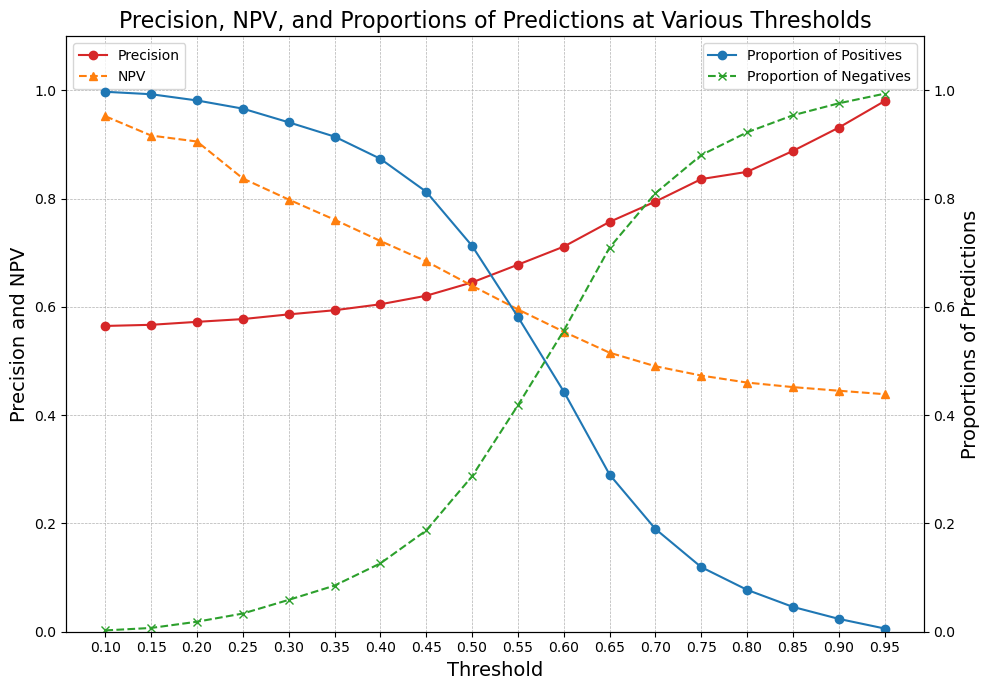

In [16]:
# The code below give the visualization of the model performance (precision and NPV) on different threshold
# The min and max threshold used in the previous are determined using this evaluation

thresholds = np.arange(0.1, 1.0, 0.05)  # Adjust this range as needed
total_cases = len(y_test_base)  # Total number of cases in the test data

precision_scores = []
npv_scores = []  # Negative Predictive Value
proportions_of_ones = []
proportions_of_zeros = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    predicted_binary = (predicted_prob > threshold).astype(int)

    # Calculate precision
    precision = precision_score(y_test_base, predicted_binary, zero_division=0)
    precision_scores.append(precision)

    # Calculate confusion matrix and then NPV
    tn, fp, fn, tp = confusion_matrix(y_test_base, predicted_binary).ravel()
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    npv_scores.append(npv)

    # Calculate the proportion of cases predicted as 1 and 0
    proportion_of_ones = np.sum(predicted_binary) / total_cases
    proportions_of_ones.append(proportion_of_ones)
    proportion_of_zeros = np.sum(1 - predicted_binary) / total_cases
    proportions_of_zeros.append(proportion_of_zeros)

# Creating dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# First plot (precision and NPV) - left y-axis
color_precision = 'tab:red'
color_npv = 'tab:orange'
ax1.set_xlabel('Threshold', fontsize=14)
ax1.set_ylabel('Precision and NPV', fontsize=14)
ax1.set_ylim(0.0, 1.1)
ax1.plot(thresholds, precision_scores, color=color_precision, marker='o', linestyle='-', label='Precision')
ax1.plot(thresholds, npv_scores, color=color_npv, marker='^', linestyle='--', label='NPV')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')
ax1.set_xticks(np.arange(0.1, 1.0, 0.05))
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Second plot (proportions of predictions) - right y-axis
ax2 = ax1.twinx()
color_positives = 'tab:blue'
color_negatives = 'tab:green'
ax2.set_ylabel('Proportions of Predictions', fontsize=14)
ax2.set_ylim(0.0, 1.1)
ax2.plot(thresholds, proportions_of_ones, color=color_positives, marker='o', linestyle='-', label='Proportion of Positives')
ax2.plot(thresholds, proportions_of_zeros, color=color_negatives, marker='x', linestyle='--', label='Proportion of Negatives')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Precision, NPV, and Proportions of Predictions at Various Thresholds', fontsize=16)
fig.tight_layout()
plt.show()

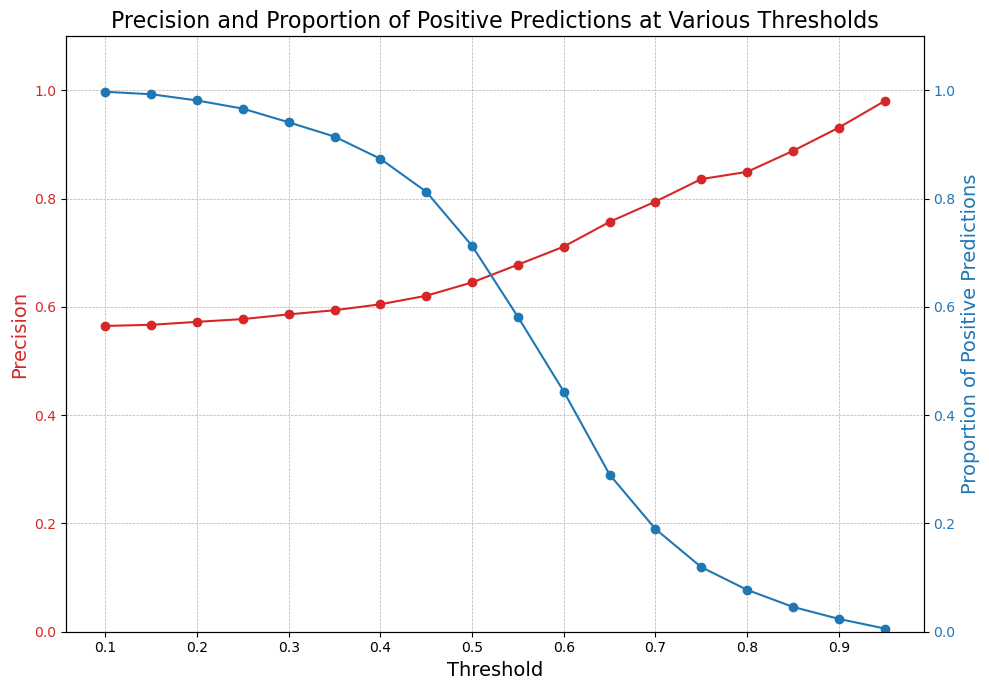

In [17]:
# Simple version of the visualization in the previous cell

thresholds = np.arange(0.1, 1.0, 0.05)  # Adjust this range as needed
total_cases = len(y_test_base)  # Total number of cases in the test data

precision_scores = []
proportions_of_ones = []

for threshold in thresholds:
    # Convert probabilities to binary predictions based on the threshold
    predicted_binary = (predicted_prob > threshold).astype(int)

    # Calculate precision
    precision = precision_score(y_test_base, predicted_binary, zero_division=0)
    precision_scores.append(precision)

    # Calculate the proportion of cases predicted as 1
    proportion_of_ones = np.sum(predicted_binary) / total_cases
    proportions_of_ones.append(proportion_of_ones)

# Creating dual-axis plot
fig, ax1 = plt.subplots(figsize=(10, 7))

# First plot (precision) - left y-axis
color = 'tab:red'
ax1.set_xlabel('Threshold', fontsize=14)
ax1.set_ylabel('Precision', color=color, fontsize=14)
ax1.set_ylim(0.0,1.1)
ax1.plot(thresholds, precision_scores, color=color, marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(np.arange(0.1, 1.0, 0.1))  # Synchronize x-axis ticks
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add checkered grid

# Second plot (proportion of positives) - right y-axis
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Proportion of Positive Predictions', color=color, fontsize=14)
ax2.set_ylim(0.0,1.1)
ax2.plot(thresholds, proportions_of_ones, color=color, marker='o', linestyle='-')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Precision and Proportion of Positive Predictions at Various Thresholds', fontsize=16)
fig.tight_layout()  # To ensure the right y-label is not clipped
plt.show()


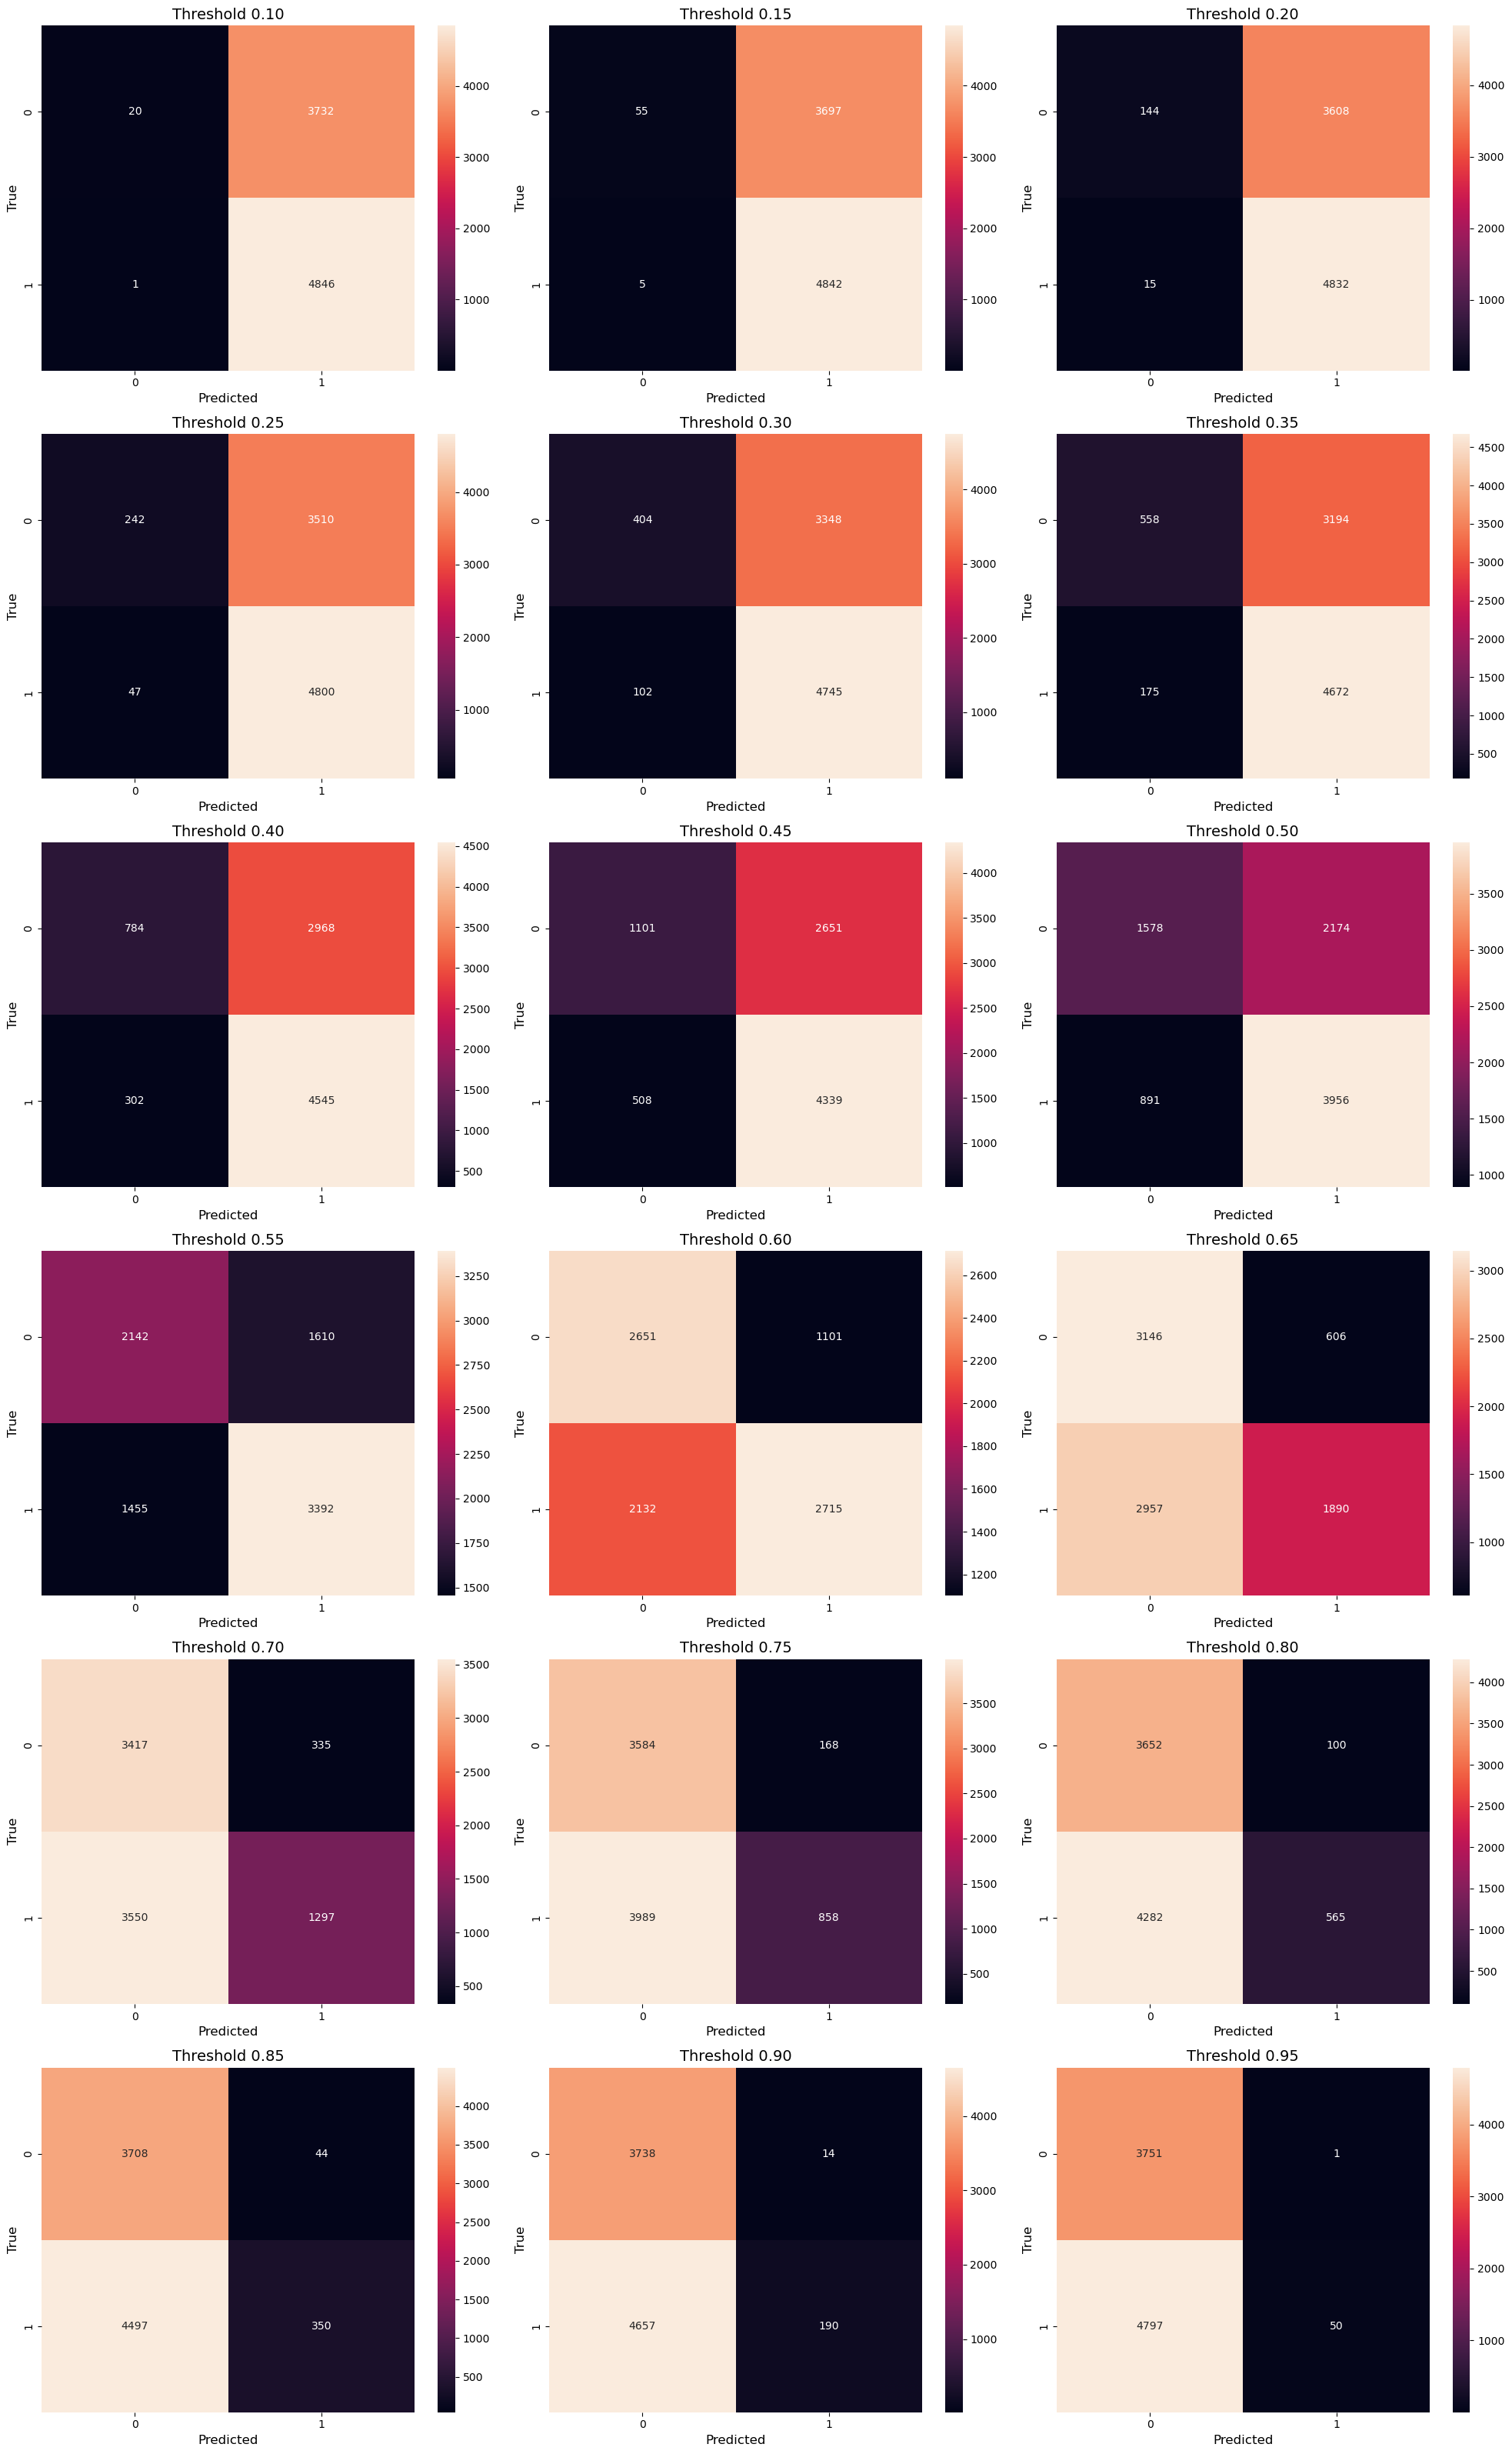

In [18]:
# Assuming predicted_prob is an array of predicted probabilities from your model
# and y_test_base is the true labels

thresholds = np.arange(0.1, 1, 0.05)  # Adjust this range as needed

# Set up the matplotlib figure with 5x4 subplots
fig, axes = plt.subplots(6, 3, figsize=(20, 32))  # Adjust the size as needed
axes = axes.ravel()  # Flatten the array of axes

for i, threshold in enumerate(thresholds):
    # Convert probabilities to binary predictions based on the threshold
    predicted_binary = (predicted_prob > threshold).astype(int)

    # Generate confusion matrix
    cm = confusion_matrix(y_test_base, predicted_binary)

    # Plotting the confusion matrix in its subplot
    sns.heatmap(cm, annot=True, fmt='g', ax=axes[i])
    axes[i].set_xlabel('Predicted', fontsize=12)
    axes[i].set_ylabel('True', fontsize=12)
    axes[i].set_title(f'Threshold {threshold:.2f}', fontsize=14)

plt.tight_layout()
plt.show()
